
# 1.2.3 Steel Industry Energy Consumption 

## Dataset Context
The **Steel Industry Energy Consumption** dataset was collected from a smart small-scale steel industry in Gwangyang, South Korea (DAEWOO Steel Co. Ltd).  
It contains **35,040 records** describing energy usage, power factors, CO₂ emissions, and load types.

### Objective
Analyze and understand energy consumption patterns in relation to time, power variables, and load type.

Source: [UCI Machine Learning Repository - Steel Industry Energy Consumption](https://archive.ics.uci.edu/dataset/851/steel+industry+energy+consumption)


## Modelo XGBOOST 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb





### Cargar dataset

In [2]:
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 5)

# Load dataset
path = 'D:\Projects\steel-energy-mlops\data\clean\steel_energy_cleaned.csv'
df = pd.read_csv(path)

print(f"Rows: {df.shape[0]} | Columns: {df.shape[1]}")

# Asegurar tipado correcto de 'date' (era object)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

df.head()

Rows: 32608 | Columns: 11


<>:5: SyntaxWarning: invalid escape sequence '\P'
<>:5: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Angel\AppData\Local\Temp\ipykernel_15740\4233829968.py:5: SyntaxWarning: invalid escape sequence '\P'
  path = 'D:\Projects\steel-energy-mlops\data\clean\steel_energy_cleaned.csv'


,date,usage_kwh,lagging_current_reactive.power_kvarh,leading_current_reactive_power_kvarh,co2(tco2),lagging_current_power_factor,leading_current_power_factor,nsm,weekstatus,day_of_week,load_type
0,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_load
1,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_load
2,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_load
3,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_load
4,2018-01-01 01:30:00,3.28,3.56,0.0,0.0,67.76,100.0,5400.0,Weekday,Monday,Light_load


### Preprocesamiento

NOTAS: 
1. No se excluyen datos atipicos
2. date se convierte de object a datetime64
3. Se elimina variables con alta correlacion a target = CO2
4. Week_Statua, Day_of_week y Load_Type se codifican como OneHot
5. Predictores X - data, Lagging_Current_Reactive.Power_kVarh, Leading_Current_Reactive_Power_kVarh, Lagging_Current_Power_Factor, Leading_Current_Power_Factor, NSM, WeekStatus, Load_Type
6. Target Y- Usage_kWh


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32608 entries, 0 to 32607
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  12085 non-null  datetime64[ns]
 1   usage_kwh                             32608 non-null  float64       
 2   lagging_current_reactive.power_kvarh  32608 non-null  float64       
 3   leading_current_reactive_power_kvarh  32608 non-null  float64       
 4   co2(tco2)                             32608 non-null  float64       
 5   lagging_current_power_factor          32608 non-null  float64       
 6   leading_current_power_factor          32608 non-null  float64       
 7   nsm                                   32608 non-null  float64       
 8   weekstatus                            32270 non-null  object        
 9   day_of_week                           32307 non-null  object        
 10

### Limpieza

In [4]:
# Eliminar filas nulas
df = df.dropna()

# Ordenar cronológicamente
df = df.sort_values(by="date")



### Caracteristicas de tiempo derivadas de 'date'

In [5]:
df['hour'] = df['date'].dt.hour
df['dayofweek_num'] = df['date'].dt.dayofweek  # 0=Mon,...,6=Sun
df['month'] = df['date'].dt.month

### One Hot Encoding para 'WeekStatus, Day_of_week y Load_Type

In [6]:
df = pd.get_dummies(df, columns=['weekstatus', 'day_of_week', 'load_type'], drop_first=True)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11729 entries, 91 to 30269
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  11729 non-null  datetime64[ns]
 1   usage_kwh                             11729 non-null  float64       
 2   lagging_current_reactive.power_kvarh  11729 non-null  float64       
 3   leading_current_reactive_power_kvarh  11729 non-null  float64       
 4   co2(tco2)                             11729 non-null  float64       
 5   lagging_current_power_factor          11729 non-null  float64       
 6   leading_current_power_factor          11729 non-null  float64       
 7   nsm                                   11729 non-null  float64       
 8   hour                                  11729 non-null  int32         
 9   dayofweek_num                         11729 non-null  int32         
 10  mo

In [9]:
df

,date,usage_kwh,lagging_current_reactive.power_kvarh,leading_current_reactive_power_kvarh,co2(tco2),lagging_current_power_factor,leading_current_power_factor,nsm,hour,dayofweek_num,month,weekstatus_Weekend,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,load_type_Maximum_load,load_type_Medium_load
91,2018-01-01 00:00:00,3.42,3.46,0.00,0.0,70.30,100.000000,0.000000,0,0,1,False,True,False,False,False,False,False,False,False
0,2018-01-01 00:30:00,4.00,4.46,0.00,0.0,66.77,100.000000,1800.000000,0,0,1,False,True,False,False,False,False,False,False,False
1,2018-01-01 00:45:00,3.24,3.28,0.00,0.0,70.28,100.000000,2700.000000,0,0,1,False,True,False,False,False,False,False,False,False
2,2018-01-01 01:00:00,3.31,3.56,0.00,0.0,68.09,100.000000,3600.000000,1,0,1,False,True,False,False,False,False,False,False,False
3,2018-01-01 01:15:00,3.82,4.50,0.00,0.0,64.72,100.000000,4500.000000,1,0,1,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30265,2018-12-12 22:30:00,4.25,3.42,0.11,0.0,77.91,99.970000,81000.000000,22,2,12,False,False,False,False,False,False,True,True,False
30266,2018-12-12 23:00:00,4.21,3.31,0.18,0.0,78.61,109.391564,82800.000000,23,2,12,False,False,False,False,False,False,True,True,False
30267,2018-12-12 23:15:00,4.14,2.88,0.32,0.0,82.09,99.700000,83700.000000,23,2,12,False,False,False,False,False,False,True,False,False
30268,2018-12-12 23:30:00,4.10,2.45,0.50,0.0,85.84,99.260000,84600.000000,23,2,12,False,False,False,False,False,False,True,False,False


### Division de datos (no-temporizado / basado en features)

In [12]:
#Eliminamos CO2 debido a la alta correlacion
#Eliminamos Day_of_Week

features = [
    # Eléctricas / de estado
    'lagging_current_reactive.power_kvarh',
    'leading_current_reactive_power_kvarh',
    'lagging_current_power_factor',
    'leading_current_power_factor',
    'nsm',
    # Tiempo
    'hour', 'dayofweek_num', 'month',
    # One-hot binaria
    'weekstatus_Weekend','load_type_Maximum_load',
    'load_type_Medium_load'
]

In [15]:
# Division de datos 80%-20%
target = 'usage_kwh'

X = df[features]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### Entrenamiento XGBoost

In [17]:
# Clasificacion
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='rmse',
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_train_pred = xgb_model.predict(X_train)

### Evaluacion

In [18]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:,.2f}')
print(f'MAE : {mae:,.2f}')
print(f'R²  : {r2:,.3f}')

print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R² :", r2_score(y_test, y_pred))


RMSE: 6.49
MAE : 2.46
R²  : 0.964
Train R²: 0.9854260533618004
Test R² : 0.9642723473282957


In [19]:
#Validacion cruzada 
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_model, X, y, scoring='r2', cv=5)
print(scores.mean(), scores.std())

0.9523231631542657 0.009601119007378716


### Ejemplo 1

In [26]:
# Datos de entrada


ejemplo1 = pd.DataFrame({
    'lagging_current_reactive.power_kvarh': [36.7],
    'leading_current_reactive_power_kvarh': [5.8],
    'lagging_current_power_factor': [98.0],
    'leading_current_power_factor': [98.0],
    'nsm': [36000],                # Seconds since midnight (10:00 a.m.)
    'hour': [10],
    'dayofweek_num': [2],          # 0=Mon ... 6=Sun
    'month': [3],
    'weekstatus_Weekend': [False],
    'load_type_Maximum_load': [True],
    'load_type_Medium_load': [False]
})

#Prediccion

ejemplo1 = ejemplo1[features]
prediction = xgb_model.predict(ejemplo1)
print(f"Prediccion Usage_kWh: {prediction[0]:.2f}")



Prediccion Usage_kWh: 55.36


In [27]:
# Datos de entrada


ejemplo2 = pd.DataFrame({
    'lagging_current_reactive.power_kvarh': [32.5],
    'leading_current_reactive_power_kvarh': [11.8],
    'lagging_current_power_factor': [93.5],
    'leading_current_power_factor': [87.2],
    'nsm': [36000],                # Seconds since midnight (10:00 a.m.)
    'hour': [10],
    'dayofweek_num': [2],          # 0=Mon ... 6=Sun
    'month': [3],
    'weekstatus_Weekend': [False],
    'load_type_Maximum_load': [True],
    'load_type_Medium_load': [False]
})

#Prediccion

ejemplo2 = ejemplo2[features]
prediction = xgb_model.predict(ejemplo2)
print(f"Prediccion Usage_kWh: {prediction[0]:.2f}")



Prediccion Usage_kWh: 57.15


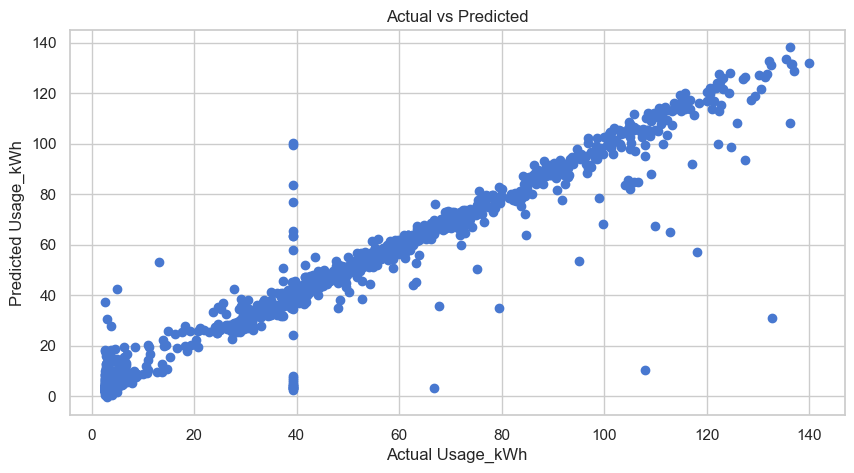

In [24]:
#Actual vs Prediccion

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Usage_kWh")
plt.ylabel("Predicted Usage_kWh")
plt.title("Actual vs Predicted")
plt.show()

In [25]:
import joblib
joblib.dump(xgb_model,"XGB_model_V0M0.pkl")

['XGB_model_V0M0.pkl']